# Xenograft SA501X3F breast cancer
> data plot and victree fixed tree inference

## Load dataset

In [1]:
import numpy as np
import pandas as pd

bio_df = pd.read_csv("/Users/zemp/phd/scilife/cpt_experiments/CONET/CONET/python/notebooks/biological_data/data/SA501X3F_filtered_corrected_counts.csv")
cell_names = bio_df.filter(like='SA501X3F').columns
bio_df.head()

,chr,start,end,width,candidate_brkp,SA501X3F.00136,SA501X3F.00268,SA501X3F.00324,SA501X3F.00164,SA501X3F.00143,...,SA501X3F.00038,SA501X3F.00103,SA501X3F.00156,SA501X3F.00357,SA501X3F.00314,SA501X3F.00344,SA501X3F.00194,SA501X3F.00302,SA501X3F.00300,SA501X3F.00375
0,1,750001,900000,150000,1,0.788418,0.997561,0.849417,0.958833,0.884363,...,1.460313,1.021588,0.802751,0.844613,1.126179,0.894077,0.886262,1.024218,0.852884,0.809327
1,1,1200001,1350000,150000,1,0.849975,0.706687,1.004793,0.880624,0.953681,...,1.088894,1.172028,0.833906,0.837472,0.831351,0.965090,0.690766,0.823925,0.589073,0.610860
2,1,1350001,1500000,150000,0,0.929382,0.642708,0.742128,0.585840,0.922690,...,0.900067,0.798808,1.036568,1.183317,1.166959,0.634227,1.183463,0.952956,0.469167,1.059823
3,1,1650001,1800000,150000,0,1.343439,0.784339,1.109889,1.091277,0.820710,...,0.665662,0.825962,0.971873,1.058432,0.923954,1.193048,0.779907,0.992012,0.907129,0.803182
4,1,1800001,1950000,150000,0,0.948423,1.101478,1.050133,1.251881,0.925633,...,0.934722,0.877758,0.716137,1.364659,0.931454,1.158391,0.682872,0.807189,0.676003,1.004426


In [2]:
import scgenome.plotting as pl
import anndata

# read as anndata
bio_ad = anndata.AnnData(bio_df[cell_names].to_numpy().T)
bio_ad.layers['copy'] = bio_ad.X
bio_ad.obs_names = cell_names

# map chr to X Y format
chr_codes = {i: str(i) for i in range(1, 23)}
chr_codes[23] = 'X'
chr_codes[24] = 'Y'

# add metadata
bio_ad.var['chr'] = bio_df['chr'].map(chr_codes).values
bio_ad.var['start'] = bio_df['start'].values
bio_ad.var['end'] = bio_df['end'].values
bio_ad.var.head()


/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/si

,chr,start,end
0,1,750001,900000
1,1,1200001,1350000
2,1,1350001,1500000
3,1,1650001,1800000
4,1,1800001,1950000


In [3]:
bio_ad = bio_ad[:, bio_ad.var['chr'].isin(['19', '20', '21', '22', 'X'])]

In [4]:
# saturate outliers
perc_thresh = 99.5
q_thresh = np.percentile(bio_ad.X, perc_thresh)
print(f"removed - set to nan - {np.sum(bio_ad.X > q_thresh)} / {bio_ad.X.size}"
      f" outliers: count > {q_thresh:.3f} ({perc_thresh}%)")
bio_ad.layers['copy'][bio_ad.X > q_thresh] = np.nan

removed - set to nan - 2725 / 544960 outliers: count > 3.096 (99.5%)


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_49035/2177831897.py:6: ImplicitModificationWarning: Trying to modify attribute `.layers` of view, initializing view as actual.
  bio_ad.layers['copy'][bio_ad.X > q_thresh] = np.nan


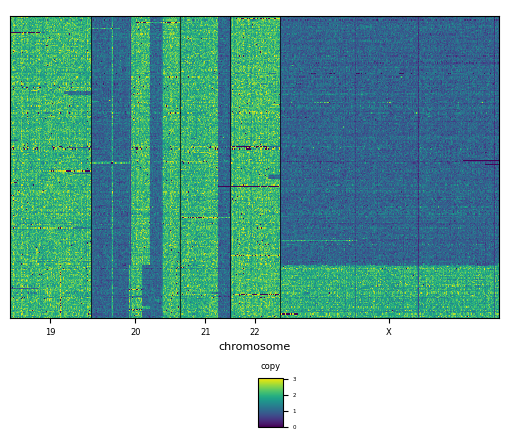

In [5]:
pl.plot_cell_cn_matrix_fig(bio_ad, layer_name='copy', raw=True);

## Load HMMCopy CN calling

## Run VICTree

### Initialization step

In [6]:
import torch
from utils.config import Config
from utils.tree_utils import star_tree
from variational_distributions.joint_dists import JointDist, FixedTreeJointDist
from variational_distributions.var_dists import qCMultiChrom, qMuTau, qEpsilonMulti, qZ
from utils.data_handling import DataHandler

In [7]:
def cell_cn_calling_from_adata(adata, n_states=7, max_iter=100, rtol=1e-2, step_size=0.2,
                      **custom_params) -> torch.Tensor:
    dh = DataHandler(adata=adata)
    
    cell_config = Config(n_cells=adata.n_obs, n_nodes=adata.n_obs + 1,
                         n_states=n_states, step_size=0.3,
                         chain_length=adata.n_vars, chromosome_indexes=dh.get_chr_idx(),
                         debug=True)
    
    cell_qmt = qMuTau(cell_config, nu_prior=1., lambda_prior=1000., alpha_prior=5000., beta_prior=500.)
    cell_qmt.initialize(method='data', obs=dh.norm_reads)
    
    cell_qc = qCMultiChrom(cell_config)
    cell_qc.initialize(method='random')
    
    cell_qeps = qEpsilonMulti(cell_config, alpha_prior=1., beta_prior=1.)
    cell_qeps.initialize(method='data', obs=dh.norm_reads)  # try varying change_ratio
    # run inference with qmt,cell-qc
    fixed_z = torch.arange(1, adata.n_obs + 1)
    cell_qz_fix = qZ(cell_config, true_params={'z': fixed_z})
    cell_tree = star_tree(adata.n_obs + 1)

    joint_q = FixedTreeJointDist(obs=dh.norm_reads, qc=cell_qc, qpsi=cell_qmt, qeps=cell_qeps, qz=cell_qz_fix)
    i = 0
    convergence = False
    curr_elbo = - np.infty
    print("running inference...")
    while not convergence and i < max_iter:
        print(f"*** {i} ***")
        if i == 0:
            print("computing initial elbo", end="")
            curr_elbo = cell_qc.compute_elbo([cell_tree], [1.], q_eps=cell_qeps)
            print(f": {curr_elbo}")

        print("qmt update")
        cell_qmt.update(cell_qc, cell_qz_fix, dh.norm_reads)
        print("qc update")
        cell_qc.update(dh.norm_reads, cell_qeps, cell_qz_fix, cell_qmt,
                         [cell_tree], [1.])
        print("qeps update")
        cell_qeps.update([cell_tree], torch.tensor([1.]), cell_qc)

        print("computing new elbo")
        new_elbo = cell_qc.compute_elbo([cell_tree], [1.], q_eps=cell_qeps)
        improvement = (new_elbo - curr_elbo) / curr_elbo
        print(f"--- [{i}] elbo: {new_elbo:.3f} (rel impr: {improvement:.3f})")
        if improvement < rtol:
            convergence = True
            print(f"converged after {i} iterations")
        curr_elbo = new_elbo
        i += 1

    return cell_qc.get_viterbi()[1:].numpy()

Running inference on single cells as clones is quite time consuming, although few iterations (6 it, ~10 minutes) are enough
to reach convergence on the qC partial elbo. The issue here is the baseline being wrong for the cells at the bottom.

In [8]:
bio_ad.layers['cn-init'] = cell_cn_calling_from_adata(bio_ad)

running inference...
*** 0 ***
computing initial elbo
qmt update
qc update
qeps update
computing new elbo
--- [0] elbo: -663956.438 (rel impr: 0.627)
*** 1 ***
qmt update
qc update
qeps update
computing new elbo
--- [1] elbo: -423686.477 (rel impr: 0.362)
*** 2 ***
qmt update
qc update
qeps update
computing new elbo
--- [2] elbo: -312356.594 (rel impr: 0.263)
*** 3 ***
qmt update
qc update
qeps update
computing new elbo
--- [3] elbo: -253922.188 (rel impr: 0.187)
*** 4 ***
qmt update
qc update
qeps update
computing new elbo
--- [4] elbo: -223940.711 (rel impr: 0.118)
*** 5 ***
qmt update
qc update
qeps update
computing new elbo
--- [5] elbo: -211264.203 (rel impr: 0.057)
*** 6 ***
qmt update
qc update
qeps update
computing new elbo
--- [6] elbo: -209192.359 (rel impr: 0.010)
converged after 6 iterations


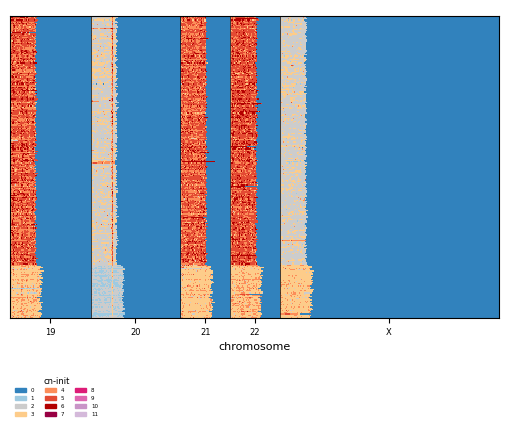

In [11]:
pl.plot_cell_cn_matrix_fig(bio_ad, layer_name='cn-init', max_cn=6);

## Run FixedTree
TODO